<a href="https://colab.research.google.com/github/jceltruda/FinGPT-TransformerPrediction/blob/Yash/PreTrainedModel_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### installs

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q -U datasets scipy ipywidgets matplotlib
!pip install jsonlines
!pip install alpaca-py
!pip install alpaca-trade-api
!pip install websockets==11.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 1.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 64.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

### login

In [2]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


### Training Data

In [5]:

from datetime import datetime, timedelta
import yfinance as yf
import json
from google.colab import drive


# Fetching the data
ticker = "AAPL"  # Ticker symbol for Dow Jones Industrial Average
# Mount your Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Change directory to where the file is saved
#%cd /content/drive/MyDrive

# Read the data from the file
import pandas as pd
data = yf.download(ticker, start="2023-01-01", end="2023-01-08")  # Example: Data for 2023


import json
import jsonlines

# Step 1: Download the data
# data = yf.download(tickers='GOOG', period='5d', interval='1m')

# Step 2: Convert the data to a list of dictionaries
data_list = data.to_dict('records')
#print(data_list)
# Step 3: Write the data to a .jsonl file
with open('data.jsonl', 'w') as f:
    for item in data_list:
        json.dump(item, f)
        f.write('\n')


"""
Credit for the following code is used from my partner Ethan Zhang that I am using for testing inputting into the model
"""
end_date = datetime.now().date()
start_date = end_date - timedelta(days=7)
# Fetch the DJIA stock data
djia_data = yf.download(ticker, start=start_date, end=end_date)
print(djia_data)

# Convert the DataFrame to a list of dictionaries
djia_records = djia_data.reset_index().to_dict('records')
output_file = "djia_stock_data.jsonl"
with open(output_file, 'w') as f:
    pass

for i in range(7, len(djia_records)):
    input_days = djia_records[i-7:i]
    output_day = djia_records[i]

    # make each input a string and each output a string with the following format:
    # input:
    # "Market Values for previous 6 days:
    # Day 1: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}, ...
    # Day 6: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}."
    # output: "Today's Market Values: Open:{open} High:{high} Low:{low} Close:{close} Adj Close:{adj close} Volume:{volume}"
    input_str = "Market Values for previous 6 days:"
    for j in range(6):
        input_str += (
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}, "
            if j != 5 else
            f"Day {j+1}: Open:{input_days[j]['Open']} High:{input_days[j]['High']} "
            f"Low:{input_days[j]['Low']} Close:{input_days[j]['Close']} Adj "
            f"Close:{input_days[j]['Adj Close']} Volume:{input_days[j]['Volume']}."
        )

    output_str = (
        f"Today's Market Values: Open:{output_day['Open']} High:{output_day['High']} "
        f"Low:{output_day['Low']} Close:{output_day['Close']} Adj "
        f"Close:{output_day['Adj Close']} Volume:{output_day['Volume']}"
    )

    # create a new record with the input and output strings
    record = {"input": input_str, "output": output_str}

    # print(str(record) + "\n")

    # write the record to the JSON Lines file
    with jsonlines.open(output_file, mode='a') as writer:
        writer.write(record)

# Open the .jsonl file
with open(output_file, 'r') as file:
    for line in file:
        json_object = json.loads(line)

        print(json_object)
        print('test')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-04-18  168.029999  168.639999  166.550003  167.039993  167.039993   
2024-04-19  166.210007  166.399994  164.080002  165.000000  165.000000   
2024-04-22  165.520004  167.259995  164.770004  165.839996  165.839996   
2024-04-23  165.350006  167.050003  164.919998  166.899994  166.899994   
2024-04-24  166.399994  169.300003  166.210007  169.020004  169.020004   

              Volume  
Date                  
2024-04-18  43122900  
2024-04-19  67772100  
2024-04-22  48116400  
2024-04-23  49537800  
2024-04-24  47315677  


In [6]:
from datetime import datetime, timedelta
import yfinance as yf
import json
from google.colab import drive


def get_past_6days(ticker):
    # Calculate the date range
    end_date = datetime.now().date()
    start_date = end_date - timedelta(days=6)  # Only need the last 6 days

    # Fetch the stock data for the given range
    data = yf.download(ticker, start=start_date, end=end_date)

    # Reset the index to handle the date column properly
    data.reset_index(inplace=True)

    # Initialize the input string to compile daily values
    input_str = "Market Values for the past 6 days:\n"

    # Loop through each day's data to format it
    for index, row in data.iterrows():
        day_number = index + 1
        daily_values = (
            f"Day {day_number}: Open:{row['Open']} High:{row['High']} "
            f"Low:{row['Low']} Close:{row['Close']} Adj "
            f"Close:{row['Adj Close']} Volume:{row['Volume']}\n"
        )
        input_str += daily_values

    return input_str

ticker = "AAPL"
market_data = get_past_6days(ticker)
print(market_data)



[*********************100%%**********************]  1 of 1 completed

Market Values for the past 6 days:
Day 1: Open:166.2100067138672 High:166.39999389648438 Low:164.0800018310547 Close:165.0 Adj Close:165.0 Volume:67772100
Day 2: Open:165.52000427246094 High:167.25999450683594 Low:164.77000427246094 Close:165.83999633789062 Adj Close:165.83999633789062 Volume:48116400
Day 3: Open:165.35000610351562 High:167.0500030517578 Low:164.9199981689453 Close:166.89999389648438 Adj Close:166.89999389648438 Volume:49537800
Day 4: Open:166.39999389648438 High:169.3000030517578 Low:166.2100067138672 Close:169.02000427246094 Adj Close:169.02000427246094 Volume:47315677



### Transformer Model

In [9]:
from transformers import AutoTokenizer
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import matplotlib.pyplot as plt


In [10]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "meta-llama/Llama-2-7b-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "/content/drive/MyDrive/FinGPT/llama2-7b-journal-finetune/checkpoint-500")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

### Model Execution

In [11]:
#Use model to predict buying or selling the data
eval_prompt = """Given the following financial input data for the past 6 days, Give only one word Buy or Sell:

### Financial Input Data:
""" +  get_past_6days("AAPL") + """
### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    output_str = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True)
    print(output_str)

[*********************100%%**********************]  1 of 1 completed


Given the following financial input data for the past 6 days, Give only one word Buy or Sell:

### Financial Input Data:
Market Values for the past 6 days:
Day 1: Open:166.2100067138672 High:166.39999389648438 Low:164.0800018310547 Close:165.0 Adj Close:165.0 Volume:67772100
Day 2: Open:165.52000427246094 High:167.25999450683594 Low:164.77000427246094 Close:165.83999633789062 Adj Close:165.83999633789062 Volume:48116400
Day 3: Open:165.35000610351562 High:167.0500030517578 Low:164.9199981689453 Close:166.89999389648438 Adj Close:166.89999389648438 Volume:49537800
Day 4: Open:166.39999389648438 High:169.3000030517578 Low:166.2100067138672 Close:169.02000427246094 Adj Close:169.02000427246094 Volume:47315677

### Output Data:
Day 5: Open:169.02000427246094 High:171.36000502929689 Low:168.5500067138672 Close:168.63000305175781 Adj Close:168.63000305175781 Volume:41375256
Day 6: Open:168.500005859375 High:168.75000305175781 Low:167.47000781250003 Close:168.36000502929689 Adj Close:168.3600

### Run testing prompts for presentation

In [ ]:
#Use model to predict closing prices
ft_model.eval()

output_file = open("djia_stock_test_output.json", 'w')
output_list = []

with open("djia_stock_test_data_prompts.json", 'r') as f:
    prompt_list = json.load(f)
    with torch.no_grad():
        for i, prompt in enumerate(prompt_list):
            print(f"Prompt {i+1}/{len(prompt_list)}")
            model_input = tokenizer(prompt, return_tensors="pt").to("cuda")
            output_str = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True)
            print(output_str)
            output_list.append(output_str)

# store output list into output_file
json.dump(output_list, output_file)


Prompt 1/69
Given the following financial input data for the past 6 days, only Output the Close value for day 7:
    ### Financial Input Data:Market Values for previous 6 days:Day 1: Open:37566.21875 High:37790.078125 Low:37495.91015625 Close:37715.0390625 Adj Close:37715.0390625 Volume:350280000, Day 2: Open:37629.23046875 High:37629.23046875 Low:37401.8515625 Close:37430.19140625 Adj Close:37430.19140625 Volume:322010000, Day 3: Open:37425.28125 High:37716.41015625 Low:37425.28125 Close:37440.33984375 Adj Close:37440.33984375 Volume:380220000, Day 4: Open:37455.4609375 High:37623.62109375 Low:37323.8203125 Close:37466.109375 Adj Close:37466.109375 Volume:299480000, Day 5: Open:37327.37109375 High:37692.921875 Low:37249.23828125 Close:37683.01171875 Adj Close:37683.01171875 Volume:362200000, Day 6: Open:37523.55078125 High:37552.37890625 Low:37373.30078125 Close:37525.16015625 Adj Close:37525.16015625 Volume:289860000.
    ### Output Data:Day 7: Open:37538.9609375 High:37575.51953125 

In [ ]:
new_output_list = []
for i in range(len(output_list)):
  # take everything after ### Output Data:
  split_str = output_list[i].split("Output Data:")
#   print(split_str[1])
  new_output_list.append(split_str[1])



new_new_output_list = []


for i in range(len(new_output_list)):
  # keep everything on the first line
  split_str = new_output_list[i].split("\n")
  print(split_str[0])
  new_new_output_list.append(split_str[0])

print(len(new_new_output_list))

bulk_output = open("DJIA_Bulk_outupt.json", 'w')
json.dump(new_new_output_list, bulk_output)

new_new_new_output_list = []
for i in range(len(new_new_output_list)):
    # keep everything after Close:
    split_str = new_new_output_list[i].split("Close:")
    print(split_str[1])
    new_new_new_output_list.append(split_str[1])

new_new_new_new_output_list = []
for i in range(len(new_new_new_output_list)):
    # keep everything before the first space
    split_str = new_new_new_output_list[i].split(" ")
    print(split_str[0])
    new_new_new_new_output_list.append(split_str[0])

print(len(new_new_new_new_output_list))
print(new_new_new_new_output_list)



# store new_new_new_new_output_list into a json file
numerical_output = open("numerical_output.json", 'w')
json.dump(new_new_new_new_output_list, numerical_output)


Day 7: Open:37538.9609375 High:37575.51953125 Low:37468.640625 Close:37480.37890625 Adj Close:37480.37890625 Volume:333820000.
Day 7: Open:37662.169921875 High:37746.890625 Low:37584.51171875 Close:37616.33984375 Adj Close:37616.33984375 Volume:344900000.
Day 7: Open:37628.0390625 High:37756.859375 Low:37628.0390625 Close:37650.078125 Adj Close:37650.078125 Volume:297960000.
Day 7: Open:37592.0390625 High:37645.5 Low:37496.26953125 Close:37517.359375 Adj Close:37517.359375 Volume:258910000.
Day 7: Open:37368.1796875 High:37457.62890625 Low:37368.1796875 Close:37416.0390625 Adj Close:37416.0390625 Volume:298930000.
Day 7: Open:37281.859375 High:37468.08984375 Low:37253.609375 Close:37415.671875 Adj Close:37415.671875 Volume:277090000.
Day 7: Open:37643.1796875 High:37669.16015625 Low:37571.390625 Close:37652.03125 Adj Close:37652.03125 Volume:310530000.
Day 7: Open:37863.80078125 High:38023.669921875 Low:37863.80078125 Close:38017.05078125 Adj Close:38017.05078125 Volume:379050000.
Day 

### Alpaca

In [ ]:
#Determine decision based on Model Output
split_str = output_str.split("Output Data:")
print("Buy" in split_str[1])
decision = 'B' if "Buy" in split_str[1] else 'S'
print(decision)

In [14]:
%cd /content/drive/MyDrive/trading_bot/

/content/drive/MyDrive/trading_bot


In [18]:
def fetch_positions_and_plot():
    positions = api.list_positions()
    total_portfolio_value = float(api.get_account().equity)
    symbols = []
    market_values = []

    if positions:
        for position in positions:
            symbols.append(position.symbol)
            market_value = float(position.market_value)
            market_values.append(market_value)

        # Create a pie chart
        plt.figure(figsize=(10, 7))
        plt.pie(market_values, labels=symbols, autopct=lambda p: '{:.1f}%'.format(round(p)) if p > 0 else '')
        plt.title('Portfolio Allocation by Stock')
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        plt.show()
    else:
        print("No current holdings.")


AAPL: 30 shares at $168.824444444
META: 50 shares at $500.657
NVDA: 95 shares at $930.2959


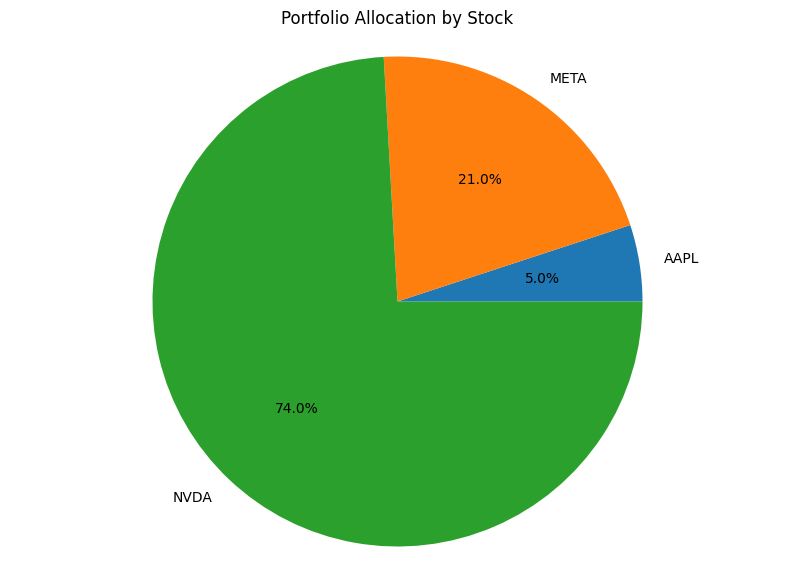

Enter a Stock Ticker to trade ==> NVDA


[*********************100%%**********************]  1 of 1 completed


Market Values for the past 6 days:
Day 1: Open:831.5 High:843.239990234375 Low:756.0599975585938 Close:762.0 Adj Close:762.0 Volume:87190500
Day 2: Open:781.0399780273438 High:800.72998046875 Low:764.0 Close:795.1799926757812 Adj Close:795.1799926757812 Volume:59634100
Day 3: Open:807.6900024414062 High:827.6900024414062 Low:802.6400146484375 Close:824.22998046875 Adj Close:824.22998046875 Volume:43855900
Day 4: Open:839.5 High:840.8200073242188 Low:791.8300170898438 Close:796.77001953125 Adj Close:796.77001953125 Volume:50961600

Given the following financial input data for the past 6 days, Give only one word Buy or Sell:

### Financial Input Data:
Market Values for the past 6 days:
Day 1: Open:831.5 High:843.239990234375 Low:756.0599975585938 Close:762.0 Adj Close:762.0 Volume:87190500
Day 2: Open:781.0399780273438 High:800.72998046875 Low:764.0 Close:795.1799926757812 Adj Close:795.1799926757812 Volume:59634100
Day 3: Open:807.6900024414062 High:827.6900024414062 Low:802.64001464843

In [20]:
from trade import *

api = setup()

# Get Current Positions and Print Pie Chart to Display Current Percentage of Holdings
positions = api.list_positions()
if positions:
    for position in positions:
        print(f"{position.symbol}: {position.qty} shares at ${position.avg_entry_price}")
    fetch_positions_and_plot()
else:
  print("No Current Positions Are Held Under This Account.")


symbol = input('Enter a Stock Ticker to trade ==> ')
info = get_past_6days(symbol)
print(info)

eval_prompt = """Given the following financial input data for the past 6 days, Give only one word Buy or Sell:

### Financial Input Data:
""" +  info + """
### Output Data:
"""

model_input = tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    output_str = tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=300)[0], skip_special_tokens=True)
    print(output_str)

split_str = output_str.split("Output Data:")
decision = 'B' if "Buy" in split_str[1] else 'S'

#decision = input('Enter B/S for buying and selling ==> ')
qty = input('Enter the number of stocks you wish to buy/sell ==> ')

trade_stock(api, symbol, decision, qty)